# Forward models

This notebook reproduces the results from the forward models presented in the paper.

It needs the reconstructed pulse shapes and Dazzler values from 240918. It is the `datasets/pulse_and_dazzler_240918.h5` (which is generated by  `pulse_reconstruction_hr.ipynb`)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import math
np.math=math #to avoid issues in 'pulse' script with new numpy

import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import models.fcnn as models_fcnn

import pulse

### LOADING THE DATASET

In [2]:
filename='datasets/pulse_and_dazzler_240918.h5'

In [3]:
#read the Dazller input data
df_input=pd.read_hdf(filename,'df_input')

#read the reconstructed pulse data
df_time_200=pd.read_hdf(filename,'df_time_200')
df_pulse_200=pd.read_hdf(filename,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots with bad goodness

In [4]:
goodness_val=1.3
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

### Define the model variables

In [5]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test = train_test_split(df_input_reduced[['order2', 'order3', 'order4']], df_pulse_200_reduced, test_size=0.3, random_state=101)

## Modeling

In [6]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


### Linear model

In [7]:
def train_lin_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    forward_model_lin=LinearRegression().fit(X_train,y_train)

    y_predict_forward=forward_model_lin.predict(X_test)
    
    #study the error distribution
    df_error_forward_lin=abs(y_test_reset-y_predict_forward)
    df_error_forward_lin=df_error_forward_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns
    
    
    return forward_model_lin, df_error_forward_lin

In [8]:
forward_model_lin,df_error_forward_lin=train_lin_forward(X_train, X_test, y_train, y_test)

### Random Forest

In [9]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=RandomForestRegressor(n_estimators=n_estimators,
                                            max_features=max_features,
                                            max_depth=max_depth,
                                              random_state=random_state)
    forward_model_rf.fit(X_train, y_train)
    y_predict_forward=forward_model_rf.predict(X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

In [10]:
forward_model_rf,df_error_forward_rf=train_rf_forward(X_train, X_test, y_train, y_test)

### Multi-Layer Perceptron

In [11]:
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(100,#epochs 
                 128,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.04957261309027672
Finished epoch 20,latest loss 0.0007503586821258068
Finished epoch 40,latest loss 0.0006078765727579594
Finished epoch 60,latest loss 0.0005452586337924004
Finished epoch 80,latest loss 0.0005096563254483044
Finished epoch 99,latest loss 0.00047938941861502826
Total time taken to train the model: 2.72s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

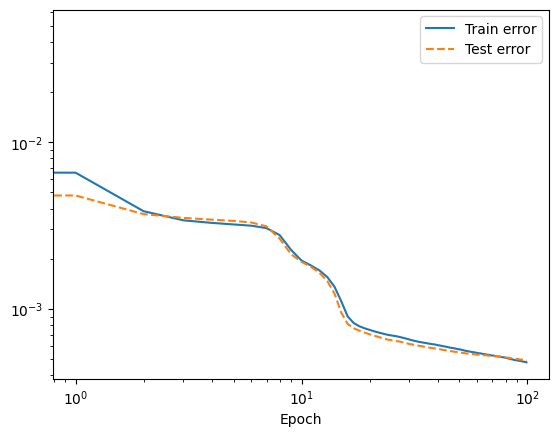

In [12]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Analytic script

This is the script developed by Sean. It takes the FTL pulse and modified based on the dispersion coefficients.

In [13]:
def shift_pulse(p):
    #shift the pulse so the peak is at thr center of the array
    return np.roll(p,int(len(p)/2)-np.argmax(p))

In [31]:
#Read the reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
#in our case -> 168758

ftl_filename='datasets/raw_pulse_ftl_168758_240918.h5'

intensity=pd.read_hdf(ftl_filename,key='intensity').to_numpy()
frequency=pd.read_hdf(ftl_filename,key='frequency').to_numpy()
phase=pd.read_hdf(ftl_filename,key='phase').to_numpy()

#parameters for pulse reconstruction
time=150
time_bins=200
t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
c = 299792458 ## speed of light in m/s
center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    

p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
p_2 =copy.deepcopy(p_ref)

#get the dispersion values from this reference shot
o2_ref=pd.read_hdf(ftl_filename,key='dazzler_input')['order2'].to_numpy()
o3_ref=pd.read_hdf(ftl_filename,key='dazzler_input')['order3'].to_numpy()
o4_ref=pd.read_hdf(ftl_filename,key='dazzler_input')['order4'].to_numpy()


script_error=[]
for shot_j in range(len(df_input_reduced)):
    p_2 =copy.deepcopy(p_ref) #fresh copy every time
    #desired pulse
    #shot_j=50
    o2_final=df_input_reduced.loc[shot_j]['order2']
    o3_final=df_input_reduced.loc[shot_j]['order3']
    o4_final=df_input_reduced.loc[shot_j]['order4']

    #add dispersion
    p_2.dispersion(2,o2_final-o2_ref)
    p_2.dispersion(3,o3_final-o3_ref)
    p_2.dispersion(4,o4_final-o4_ref)

    #shift the pulses so the peak at the center
    p2_s=shift_pulse(p_2.intensity)
    pmeas_s=shift_pulse(df_pulse_200_reduced.iloc[shot_j]) #measured shot 

    #mae error
    error=abs(p2_s-pmeas_s)
    error=error.sum()/len(p2_s)
    script_error.append(error)
script_error=np.array(script_error)

### Plotting

In [35]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [36]:
def plot_example(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_lin,forward_model_rf,forward_model_mlp):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_lin=forward_model_lin.predict(X_values)
    y_predict_forward_rf=forward_model_rf.predict(X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_lin[0],label='Prediction (Linear)',linewidth=3,linestyle='-')
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')

    mae_lin=abs(y_test.iloc[shot_index]-y_predict_forward_lin[0])
    mae_lin=mae_lin.sum()/len(y_test.iloc[shot_index])
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+str(order4), dict(size=14))
    plt.text(-120,0.7,r'$MAE_{{Lin}}={:.1f}$%'.format(100*mae_lin))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

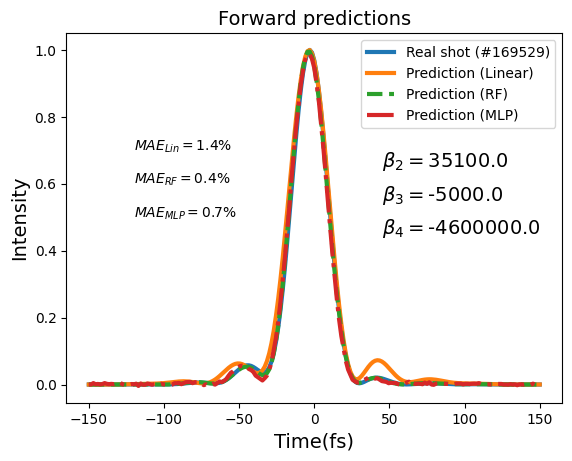

In [37]:
shot_index=75
plot_example(shot_index,X_test,y_test,df_input_reduced,df_time_200,
             forward_model_lin,forward_model_rf,forward_model_mlp)

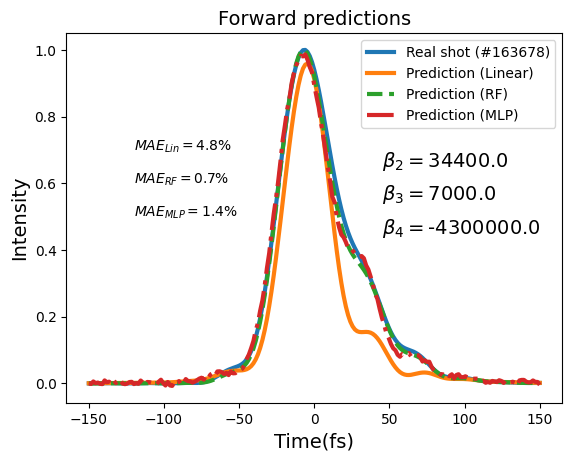

In [38]:
shot_index=512
plot_example(shot_index,X_test,y_test,df_input_reduced,df_time_200,
             forward_model_lin,forward_model_rf,forward_model_mlp)

## Error distribution and impact of dataset size

In [39]:
def drop_shots(drop_factor,df_input,df_time):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

### Generate the smaller datasets

In [40]:
drop_factor=0.45
df_input_subset_1500,df_time_subset_1500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.60
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.81
df_input_subset_500,df_time_subset_500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 1494
The datasize is no: 1087
The datasize is no: 517


In [42]:
#split the dataset (X:dazzler param, Y:wizzler) 
X_train_1500, X_test_1500, y_train_1500, y_test_1500=train_test_split(df_input_subset_1500[['order2', 'order3', 'order4']],df_time_subset_1500,test_size=0.3, random_state=101)
X_train_1k, X_test_1k, y_train_1k, y_test_1k=train_test_split(df_input_subset_1k[['order2', 'order3', 'order4']],df_time_subset_1k,test_size=0.3, random_state=101)
X_train_500, X_test_500, y_train_500, y_test_500=train_test_split(df_input_subset_500[['order2', 'order3', 'order4']],df_time_subset_500,test_size=0.3, random_state=101)


### Train the models on the smaller datasets

In [43]:
#Training the Random Forest forward models
forward_model_rf_1500,df_error_forward_rf_1500=train_rf_forward(X_train_1500, X_test_1500, y_train_1500, y_test_1500)
forward_model_rf_1k,df_error_forward_rf_1k=train_rf_forward(X_train_1k, X_test_1k, y_train_1k, y_test_1k)
forward_model_rf_500,df_error_forward_rf_500=train_rf_forward(X_train_500, X_test_500, y_train_500, y_test_500)

In [44]:
#Training the MLP forward models
forward_model_mlp_1500=models_fcnn.FWmodelNN(X_train_1500,y_train_1500,X_test_1500,y_test_1500,device)
forward_model_mlp_1500.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_1500=forward_model_mlp_1500.predict(X_test_1500)
error_fwd_model_mlp_1500=forward_model_mlp_1500.error_calc_mae()
print()

forward_model_mlp_1k=models_fcnn.FWmodelNN(X_train_1k,y_train_1k,X_test_1k,y_test_1k,device)
forward_model_mlp_1k.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_1k=forward_model_mlp_1k.predict(X_test_1k)
error_fwd_model_mlp_1k=forward_model_mlp_1k.error_calc_mae()

print()
forward_model_mlp_500=models_fcnn.FWmodelNN(X_train_500,y_train_500,X_test_500,y_test_500,device)
forward_model_mlp_500.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_500=forward_model_mlp_500.predict(X_test_500)
error_fwd_model_mlp_500=forward_model_mlp_500.error_calc_mae()

Finished epoch 0,latest loss 0.027238527312874794
Finished epoch 20,latest loss 0.0006969449459575117
Finished epoch 40,latest loss 0.0005688972887583077
Finished epoch 60,latest loss 0.0004923851229250431
Finished epoch 80,latest loss 0.00045500826672650874
Finished epoch 99,latest loss 0.00042548435158096254
Total time taken to train the model: 3.68s
Calculating the Mean Absolute Error

Finished epoch 0,latest loss 0.03631848841905594
Finished epoch 20,latest loss 0.0007347752689383924
Finished epoch 40,latest loss 0.0006062871543690562
Finished epoch 60,latest loss 0.0005193197284825146
Finished epoch 80,latest loss 0.0004663628642447293
Finished epoch 99,latest loss 0.00042072247015312314
Total time taken to train the model: 2.69s
Calculating the Mean Absolute Error

Finished epoch 0,latest loss 0.05989998206496239
Finished epoch 20,latest loss 0.0018692795420065522
Finished epoch 40,latest loss 0.0008644206100143492
Finished epoch 60,latest loss 0.0006559919565916061
Finished epoc

       Analytic    Linear        RF       MLP
0     10.572439  1.816867  0.339681  0.500923
1      7.685112  1.268100  0.260936  0.353827
2      7.530497  2.881495  3.897119  3.803907
3      5.689584  3.450849  1.187995  1.930804
4      5.241778  0.957061  0.627136  0.924272
...         ...       ...       ...       ...
2711   2.519960       NaN       NaN       NaN
2712   2.444384       NaN       NaN       NaN
2713   2.545545       NaN       NaN       NaN
2714   2.472945       NaN       NaN       NaN
2715   2.440944       NaN       NaN       NaN

[2716 rows x 4 columns]
        Error Dataset Model
0    0.602606     500    RF
1    1.492148     500    RF
2    0.693495     500    RF
3    1.227703     500    RF
4    0.890440     500    RF
..        ...     ...   ...
810  0.570662    3000   MLP
811  0.836917    3000   MLP
812  0.711154    3000   MLP
813  1.358613    3000   MLP
814  0.610661    3000   MLP

[3494 rows x 3 columns]


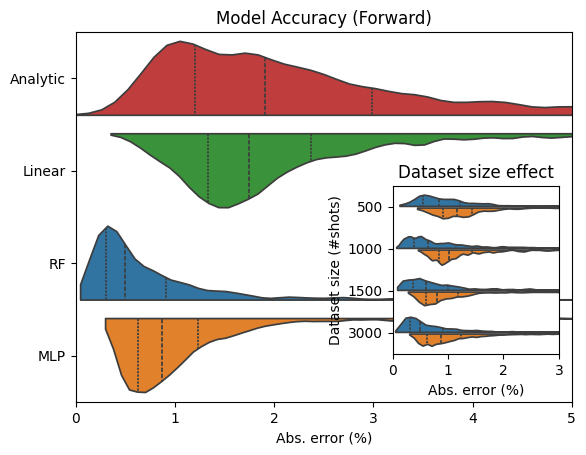

In [45]:
fig = plt.figure() #fig needed to add_axes later

df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=True,orient='h',
               palette=['tab:red','tab:green','tab:blue','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.xlim(0,5)

#inset plot
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

ax = fig.add_axes([0.62, 0.21, 0.26, 0.35], facecolor='white') #[left, bottom, width, height]
#sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Dataset size (#shots)')
plt.title('Dataset size effect')
#plt.ylim(0,3)
plt.xlim(0,3)
ax.get_legend().remove()

## Different day

In [56]:
filename_dd='datasets/pulse_and_dazzler_250313.h5'

#read the Dazller input data
df_input_dd=pd.read_hdf(filename_dd,'df_input')

#read the reconstructed pulse data
df_time_dd_200=pd.read_hdf(filename_dd,'df_time_200')
df_pulse_dd_200=pd.read_hdf(filename_dd,'df_pulse_200')
t_200=df_time_dd_200.to_numpy()

### Drop shots with bad goodness

In [57]:
df_input_dd_reduced=df_input_dd[df_input_dd['goodness']>goodness_val]

good_shots_list_dd=df_input_dd_reduced.index.values
#print(good_shots_list)
df_pulse_dd_200_reduced=df_pulse_dd_200.iloc[good_shots_list_dd]

#reset the index
df_input_dd_reduced.reset_index(inplace=True,drop=True)
df_pulse_dd_200_reduced.reset_index(inplace=True,drop=True)

In [58]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(df_input_dd_reduced[['order2', 'order3', 'order4']], df_pulse_dd_200_reduced, test_size=0.3, random_state=101)

### Train FWD model

In [59]:
forward_model_rf_dd,df_error_forward_rf_dd=train_rf_forward(X_train_dd, X_test_dd, y_train_dd, y_test_dd)

### Use the RF trained on 250313 and use it to predict 240918

In [60]:
#NOTE the model and the train/test are different days
y_predict_forward_dd=forward_model_rf_dd.predict(X_test)

#study the erro distribution
y_test_reset=y_test.reset_index(drop=True)
df_error_forward_rf_notrain=abs(y_test_reset-y_predict_forward_dd)
df_error_forward_rf_notrain=df_error_forward_rf_notrain.sum(axis=1)/y_test.shape[1] #sum error / num columns

       250313    240918  240918\n (pretrained)
0    0.182461  0.339681               2.074234
1    0.262120  0.260936               1.224666
2    0.204000  3.897119               5.468787
3    0.091685  1.187995               5.534680
4    0.227644  0.627136               2.194128
..        ...       ...                    ...
810       NaN  0.346261               2.017151
811       NaN  0.648639               0.774160
812       NaN  0.877197               2.637364
813       NaN  0.728918               1.401701
814       NaN  0.270659               1.169239

[815 rows x 3 columns]


([0, 1, 2],
 [Text(0, 0, '250313'),
  Text(0, 1, '240918'),
  Text(0, 2, '240918\n (pretrained)')])

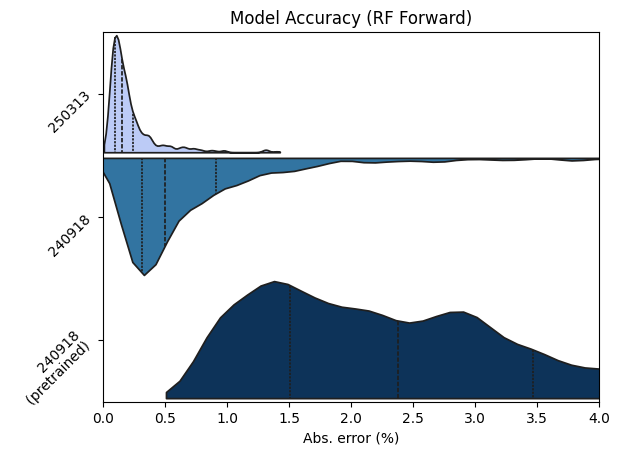

In [61]:
df_plot=pd.DataFrame({'250313':100*df_error_forward_rf_dd,
                      '240918':100*df_error_forward_rf,
                      '240918\n (pretrained)':100*df_error_forward_rf_notrain})
#df_plot=pd.DataFrame({'240918 using \n pretrained model':100*df_error_forward_rf_notrain,
#                      '250313':100*df_error_forward_rf_dd})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=1,bw_adjust=.4,split=True,orient='h',width=0.95,
#              palette=['tab:orange','tab:blue','tab:green'])
              palette=['#b3c6ff', 'tab:blue', '#003366'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (RF Forward)')
plt.xlim(0,4)
plt.yticks(rotation=45)